This notebook perform the following analysis:

FIrst, the notebook starts by loading data from external URLs, specifically datasets containing information about males and females.

1. *Model vs Human Accuracy*: It calculates and compares the accuracy of a model versus human accuracy. This includes overall accuracy, as well as specific accuracies for female, male, and mixed-gender pairs (where the true gender is different from the false gender).

2. *Model vs Human Accuracy Comparison*: The notebook further analyzes and compares cases where both the model and humans were correct, one was correct, or both were wrong.

3. *Distribution of Errors*: It also analyzes the distribution of images by the number of errors made by both the model and humans, visualizing how often each image was misclassified.

In [3]:
#@title Load Data
import requests
import pandas as pd

FEMALES_URL = 'https://raw.githubusercontent.com/zurbb/FaceTones/main/gui/females.txt'
MALES_URL = 'https://raw.githubusercontent.com/zurbb/FaceTones/main/gui/male.txt'
CSV_URL = 'https://raw.githubusercontent.com/zurbb/FaceTones/main/FaceTones_game_log.csv'

TRUE_IMAGE_ID_COL = 'True image id'
FALSE_IMAGE_ID_COL = 'False image id'
USER_CHOICE_COL = 'User choice'
MODEL_CHOICE_COL = 'Model choice'
TRUE_IMAGE_GENDER_COL = 'True image id gender'
FALSE_IMAGE_GENDER_COL = 'False image id gender'
USER_IS_RIGHT_COL = 'User is right'
MODEL_IS_RIGHT_COL = 'Model is right'

def get_names(txt_url):
    response = requests.get(txt_url)
    response.raise_for_status()
    return [name for name in response.text.split('\n') if name]

df = pd.read_csv(CSV_URL)

females_id = get_names(FEMALES_URL)
males_id = get_names(MALES_URL)

def get_gender(image_id):
    if image_id in females_id:
        return 'Female'
    elif image_id in males_id:
        return 'Male'
    else:
        raise ValueError(f"Unknown image ID: {image_id}")

df[TRUE_IMAGE_GENDER_COL] = df[TRUE_IMAGE_ID_COL].apply(get_gender)
df[FALSE_IMAGE_GENDER_COL] = df[FALSE_IMAGE_ID_COL].apply(get_gender)

df[USER_IS_RIGHT_COL] = df[TRUE_IMAGE_ID_COL] == df[USER_CHOICE_COL]
df[MODEL_IS_RIGHT_COL] = df[TRUE_IMAGE_ID_COL] == df[MODEL_CHOICE_COL]



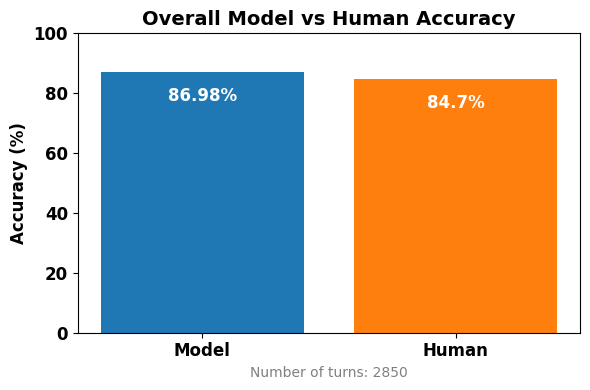

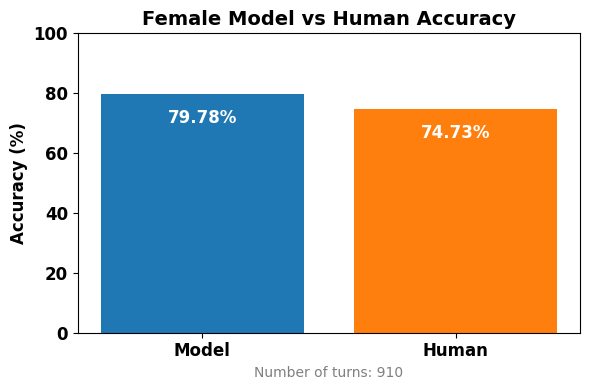

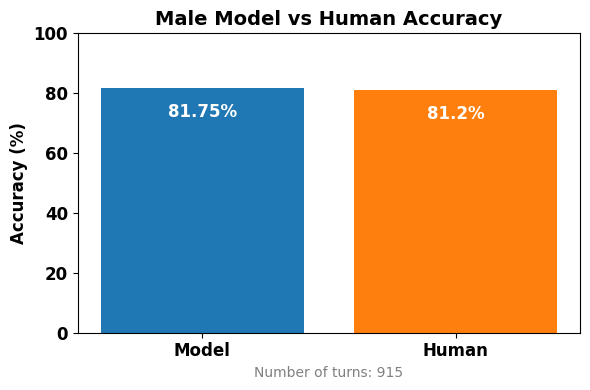

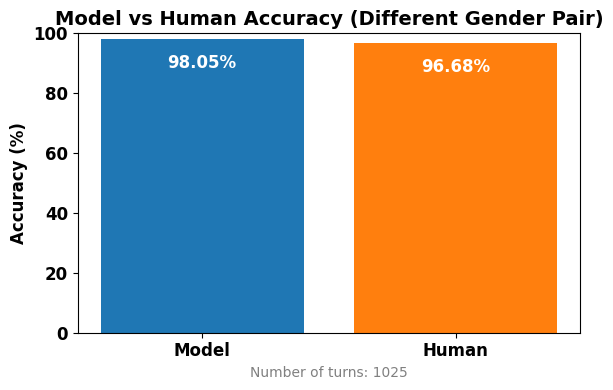

In [6]:
#@title Model vs Human Accuracy

import matplotlib.pyplot as plt

# Overall Accuracy
overall_model_accuracy = df[MODEL_IS_RIGHT_COL].mean() * 100
overall_human_accuracy = df[USER_IS_RIGHT_COL].mean() * 100
overall_sample_size = len(df)

# Female Accuracy
female_df = df[(df[TRUE_IMAGE_GENDER_COL] == 'Female') & (df[FALSE_IMAGE_GENDER_COL] == 'Female')]
female_model_accuracy = female_df[MODEL_IS_RIGHT_COL].mean() * 100
female_human_accuracy = female_df[USER_IS_RIGHT_COL].mean() * 100
female_sample_size = len(female_df)

# Male Accuracy
male_df = df[(df[TRUE_IMAGE_GENDER_COL] == 'Male') & (df[FALSE_IMAGE_GENDER_COL] == 'Male')]
male_model_accuracy = male_df[MODEL_IS_RIGHT_COL].mean() * 100
male_human_accuracy = male_df[USER_IS_RIGHT_COL].mean() * 100
male_sample_size = len(male_df)

# Mixed Gender Accuracy (True gender is not the false gender)
mixed_df = df[df[TRUE_IMAGE_GENDER_COL] != df[FALSE_IMAGE_GENDER_COL]]
mixed_model_accuracy = mixed_df[MODEL_IS_RIGHT_COL].mean() * 100
mixed_human_accuracy = mixed_df[USER_IS_RIGHT_COL].mean() * 100
mixed_sample_size = len(mixed_df)

def create_bar_plot(title, subtitle, model_accuracy, human_accuracy):
    fig, ax = plt.subplots(figsize=(6, 4))

    bars = ax.bar(['Model', 'Human'], [model_accuracy, human_accuracy], color=['#1f77b4', '#ff7f0e'])

    for bar, accuracy in zip(bars, [model_accuracy, human_accuracy]):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval - 5, f'{round(accuracy, 2)}%',
                ha='center', va='top', color='white', fontsize=12, fontweight='bold')

    ax.set_ylim([0, 100])
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(subtitle, fontsize=10, color='gray')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plots
create_bar_plot('Overall Model vs Human Accuracy', f'Number of turns: {overall_sample_size}', overall_model_accuracy, overall_human_accuracy)
print()
create_bar_plot('Female Model vs Human Accuracy', f'Number of turns: {female_sample_size}', female_model_accuracy, female_human_accuracy)
print()
create_bar_plot('Male Model vs Human Accuracy', f'Number of turns: {male_sample_size}', male_model_accuracy, male_human_accuracy)
print()
create_bar_plot('Model vs Human Accuracy (Different Gender Pair)', f'Number of turns: {mixed_sample_size}', mixed_model_accuracy, mixed_human_accuracy)

<ipython-input-7-198d89db32b3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=confusion_counts.index, y=confusion_counts.values, palette="muted")


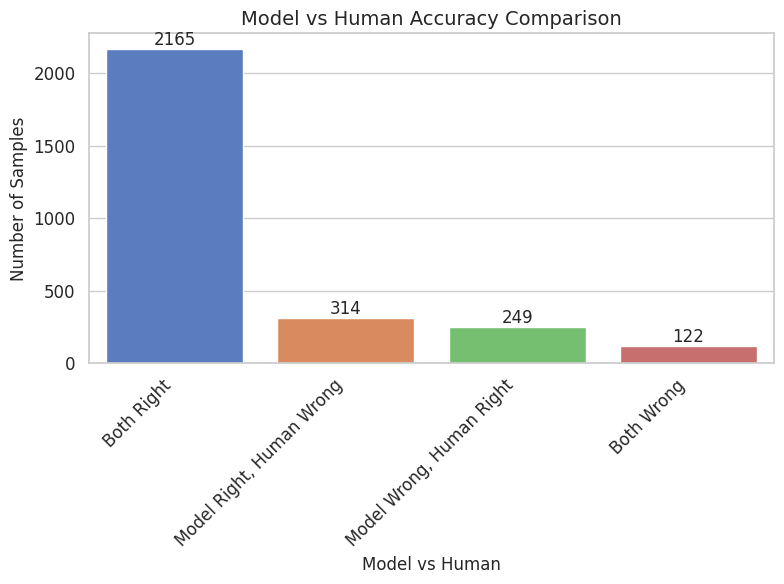

In [7]:
#@title Model vs Human Accuracy Comparison
import seaborn as sns
import matplotlib.pyplot as plt

df['Model vs Human'] = df.apply(lambda row: 'Both Right' if row[MODEL_IS_RIGHT_COL] and row[USER_IS_RIGHT_COL]
                                else 'Model Right, Human Wrong' if row[MODEL_IS_RIGHT_COL] and not row[USER_IS_RIGHT_COL]
                                else 'Model Wrong, Human Right' if not row[MODEL_IS_RIGHT_COL] and row[USER_IS_RIGHT_COL]
                                else 'Both Wrong', axis=1)

confusion_counts = df['Model vs Human'].value_counts()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=confusion_counts.index, y=confusion_counts.values, palette="muted")

for i, count in enumerate(confusion_counts.values):
    ax.text(i, count + 0.5, f'{count}', ha='center', va='bottom', fontsize=12)

plt.ylabel('Number of Samples', fontsize=12)
plt.title('Model vs Human Accuracy Comparison', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


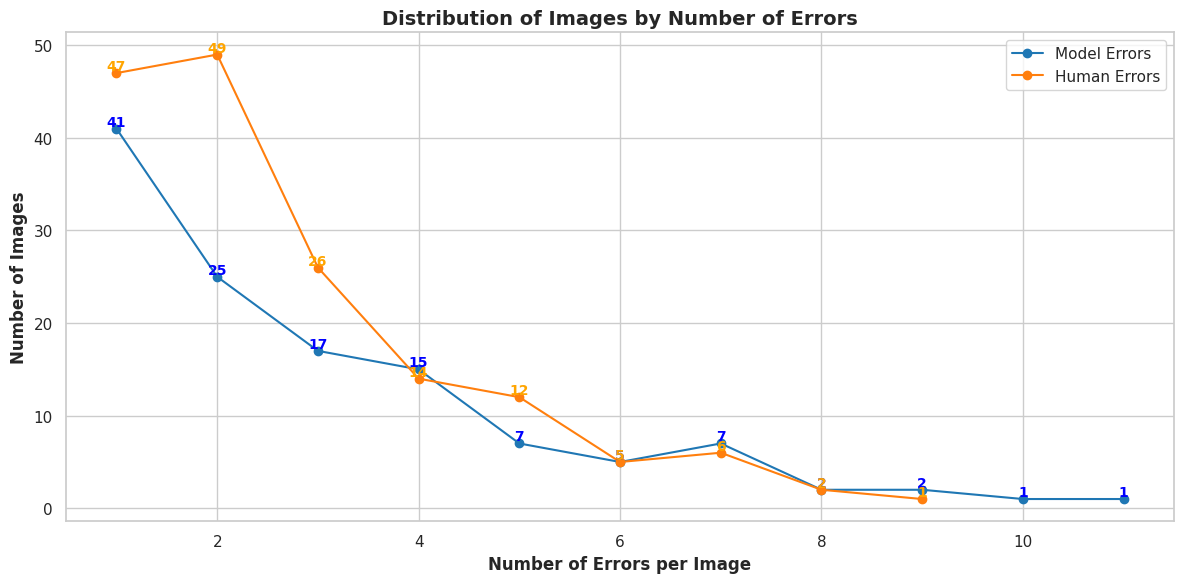

In [8]:
#@title Distribution of Images by Number of Errors
import seaborn as sns
import matplotlib.pyplot as plt

model_wrong_counts = df[df[MODEL_IS_RIGHT_COL] == False][TRUE_IMAGE_ID_COL].value_counts()
human_wrong_counts = df[df[USER_IS_RIGHT_COL] == False][TRUE_IMAGE_ID_COL].value_counts()

model_error_distribution = model_wrong_counts.value_counts().sort_index()
human_error_distribution = human_wrong_counts.value_counts().sort_index()

plt.figure(figsize=(12, 6))

plt.plot(model_error_distribution.index, model_error_distribution.values, marker='o', color='#1f77b4', label='Model Errors')

plt.plot(human_error_distribution.index, human_error_distribution.values, marker='o', color='#ff7f0e', label='Human Errors')

for i, count in enumerate(model_error_distribution.values):
    plt.text(model_error_distribution.index[i], count, f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='blue')

for i, count in enumerate(human_error_distribution.values):
    plt.text(human_error_distribution.index[i], count, f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='orange')

plt.title('Distribution of Images by Number of Errors', fontsize=14, fontweight='bold')
plt.xlabel('Number of Errors per Image', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
